# ⚽ Sports Analytics - Premier League (2019 - 2025)<br>
**Author:** Alvin Ong <br>
**Last Updated:** March 2025  
**Tools Used:** Python (pandas, matplotlib, seaborn), SQLite  

------------------------------------------------------------------------

## Table of Contents
1. [Project Overview](#project-overview)
    - [Business Context](#business-context)
    - [Business Goals](#business-goals)
    - [Expected Deliverables](#expected-deliverables)
    - [Prior Knowledge and Data Context](#prior-knowledge-and-data-context)
2. [Data Wrangling](#data-wrangling)
    - [Dataset Overview](#dataset-overview)
    - [Notes on Data Cleaning](#notes-on-data-cleaning)
    - [Data Relationships](#data-relationships)
    - [Data Loading](#data-loading)
3. [Exploratory Data Analysis](#exploratory-data-analysis)
    - [League-Level Analysis](#league-level-analysis)
        - [Goals vs Expected Goals](#insights-total-goals-vs-total-xg-2019-2024)
        - [Disciplinary Trends](#insights-yellow-and-red-card-trends)
    - [Team-Level Analysis](#team-level-analysis)
        - [Top Goal Scorers & Efficiency](#1️⃣-top-goal-scorers--most-efficient)
        - [Team Performance Evolution](#2️⃣-team-performance-evolution)
        - [Player Trends](#3️⃣-player-trends)
4. [Conclusion & Next Steps](#conclusion--next-steps)


## Project Overview

### Business Context
The Premier League is one of the most prestigious football leagues globally, attracting millions of viewers and generating significant financial and cultural impact. Football clubs, analysts, and enthusiasts are increasingly leveraging data to gain competitive advantages on and off the pitch.

This project originates from a sports analytics perspective, where I aim to derive meaningful insights from historical Premier League data. The data covers the last 6 seasons and includes the standard player-level and team-level performance metrics.

### Business Goals
The primary goal of this project is to explore, understand, and model player and team performances using statistical methods and machine learning techniques. The insights generated can help stakeholders answer key questions such as:
- Which players have been the most effective goal scorers and creators?
- How does a team's possession correlate with their goal-scoring success?
- Are there notable trends in player or team performance over time?
- Can we segment players into meaningful clusters based on their attributes?
- Are there correlations between defensive solidity and attacking output.
- Can we predict goal output using regression models.

### Expected Deliverables
The deliverable from this project is a comprehensive analysis notebook that will:
- Summarize key findings in the form of visualizations and insights.
- Identify patterns and trends for reporting purposes.
- Serve as a foundation for further advanced modeling (e.g., regression or forecasting).
- Be shared internally with analysts, coaches, or decision-makers in the form of a report or dashboard.

### Prior Knowledge and Data Context
The data is sourced from the FBref database via ```soccerdata``` and focuses exclusively on Premier League matches across the last 6 seasons. It includes detailed metrics such as goals, assists, possession, expected goals (xG), and progressive actions (actions that move the ball towards the opponent's goal line).

Note that this dataset does not currently include injury data or certain defensive metrics, which may limit the scope of some analyses. Additionally, xG values are based on modeling estimates and may not fully capture all nuances of match outcomes.


## Data Wrangling

### Dataset Overview
In this analysis, we will be working with player and team statistics from the Premier League, loaded from a SQLite database. The primary tables include:

- **playerstatistics**: Contains player-level statistics such as goals, assists, expected goals (xG), expected assists (xA), progressive passes, and Yellow/Red Cards.
- **teamstatistics**: Contains team-level aggregate statistics like total goals, possession percentage, Yellow/Red cards, and squad usage metrics.

### Notes on Data Cleaning
The dataset has already been pre-processed and cleaned in a separate notebook prior to this analysis. The data cleaning process included:
- Flattened Table Headers
- Drop unneccesary columns
- Renamed Headers for better clarity
- Correcting inconsistent column data types.

All major wrangling tasks have been documented and executed previously to ensure this notebook focuses purely on analysis.

### Data Relationships
- **PlayerStatistics** is linked to **players** via `Player`.
- **PlayerStatistics** and **TeamStatstics** are linked to **Teams** via `Team`,  **Seasons** via `Name`, and **League** via `Name`.

The following section will load the cleaned dataset from the SQLite database and perform basic checks to verify its readiness for analysis.

### Data Loading

In [40]:
# importing dependencies
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Connect to SQLite database
conn = sqlite3.connect("../data/FBref_football_stats.db")

## Exploratory Data Analysis

### League-Level Analysis
- Overall season metrics (e.g., avg goals per game, xG trends, discipline trend)


In [71]:
# Overall Season metrics

query = """
SELECT 
    Season,
    AVG(Goals) AS AvgGoalsPerGame,
    AVG(ExpectedGoals) AS AvgExpectedGoals,
    AVG(YellowCards) AS AvgYellowCards,
    AVG(RedCards) AS AvgRedCards
FROM 
    TeamStatistics
WHERE
    Season != '2425'
GROUP BY 
    Season
ORDER BY 
    Season;
"""
season_metrics = pd.read_sql(query, conn)

# Plot trends for goals, and xG
fig1 = px.line(season_metrics, x='Season', y=[
            'AvgGoalsPerGame', 
            'AvgExpectedGoals'
            ],
            title="Overall Season Metrics: Goals and xG Trends",
            labels={"value": "Average Metric", "Season": "Season"},
            markers=True)
fig1.update_layout(legend_title_text="Metrics")
fig1.show()

# Plot trends for yellow and red cards
fig2 = px.line(season_metrics, x='Season', y=[
            'AvgYellowCards', 
            'AvgRedCards'
            ],
            title="Overall Season Metrics: Yellow and Red Cards Trends",
            labels={"value": "Average Metric", "Season": "Season"},
            markers=True)
fig2.update_layout(legend_title_text="Metrics")
fig2.show()

#### Insights: Total Goals vs Total xG (2019-2024)
**Positive Trend**:  
Both **average goals per game** and **average expected goals (xG)** have shown a positive trend for the last 4 seasons, indicating an overall improvement in attacking play and chance creation in the league.

**Notable Trends**:  
A significant gap is observed where average expected goals (xG) were **higher** than average goals scored, suggesting inefficiency in finishing or strong defensive performances during the 2019-2020 and 2022-2023 Seasons.

**General Observation**:  
The alignment between goals and xG in most seasons suggests that teams are generally converting chances at an expected rate.  
However, the notable gaps in the 1920 and 2223 seasons highlight potential areas for further analysis, such as whether these trends were driven by specific teams, players, or tactical shifts in the league.

#### Insights: Yellow and Red Card Trends (2019-2024)
**Red Card Trends**:  
The **average red cards per game** have remained steady, hovering in the **1-2 range** across all seasons. This indicates consistent disciplinary patterns in terms of severe fouls or misconduct.

**Yellow Card Trends**:  
There has been a **steady increase in average yellow cards per game** over the past 4 seasons, suggesting a rise in less severe fouls or tactical fouls being penalized by referees.  
This trend may also reflect **stricter rules and refereeing standards**, leading to more frequent bookings for minor infractions.

**General Observation**:  
The stability in red cards suggests that teams and players are not engaging in significantly more dangerous play over time.  
The increase in yellow cards could indicate a combination of **stricter enforcement of rules, more aggressive defensive tactics**, or a rise in **tactical fouling** to disrupt opposition play. This trend warrants further analysis to understand its root causes.

### Team-Level Analysis
- Track possession percentages across seasons for each team
- Analyze team age profiles and their correlation with performance
- Compare progressive actions (ProgressiveCarries, ProgressivePasses) by team across seasons
- Study how teams' expected goals vs. actual goals have changed over time

In [73]:
# Track Possession Percentages Across Seasons for Each Team
query = """
SELECT 
    Team, 
    Season, 
    Possession AS AvgPossession
FROM 
    TeamStatistics
GROUP BY 
    Team, Season
ORDER BY 
    Team, Season;
"""
team_possession = pd.read_sql(query, conn)

fig_possession = px.line(team_possession, x='Season', y='AvgPossession', color='Team', markers=True,
                         title="Team Possession Percentages Across Seasons",
                         labels={"AvgPossession": "Average Possession (%)", "Season": "Season"},
                         hover_name='Team')

# Add a callback to highlight the selected team
fig_possession.update_layout(
    legend=dict(
        itemclick="toggleothers",
        itemdoubleclick="toggle"
    )
)

fig_possession.show()

#### Insights: Team posession percentages (2019-2025)
**Consistent High Possession Teams:**  
Manchester City and Liverpool have consistently maintained the highest possession percentages across seasons, reflecting their dominance in controlling games through ball retention.

**Waning Dominance and convergence in possession percentages:**  
In the most recent season, the possession dominance of Manchester City and Liverpool has been sharply declined, indicating a potential tactical shift or increased competition from other teams. Possession percentages across teams appear to be converging, with a more even distribution among all teams. This suggests a trend toward greater tactical balance in the league, where no single team dominates possession as heavily as before.

In [ ]:
# Analyze team efficiency to convert possession into goals
query = """
SELECT Team, AVG(Possession) AS AvgPossession, SUM(Goals) AS TotalGoals
FROM TeamStatistics
GROUP BY Team
ORDER BY TotalGoals DESC;
"""
team_efficiency = pd.read_sql(query, conn)

# Create the interactive scatter plot
fig = px.scatter(team_efficiency, x='AvgPossession', y='TotalGoals', color='Team',
                 title="Team Efficiency: Possession vs Goals",
                 labels={"AvgPossession": "Average Possession (%)", "TotalGoals": "Total Goals"},
                 hover_name='Team')

# Fit a linear regression model
X = team_efficiency[['AvgPossession']]
y = team_efficiency['TotalGoals']
model = LinearRegression().fit(X, y)
line_x = np.linspace(X.min(), X.max(), 100)
line_y = model.predict(line_x)

# Add the regression line to the plot
fig.add_trace(go.Scatter(x=line_x.flatten(), y=line_y, mode='lines', name='Regression Line', line=dict(color='black')))

fig.update_layout(showlegend=True)
fig.show()

e:\Users\abin\Documents\Data Analysis Docs\Python Projects\sports-analytics-premier-league\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



#### Insights: Team Efficiency (Possession vs Goals)
**High Possession, High Goals:**  
Teams like **Manchester City** and **Liverpool** consistently combine high possession percentages with a high number of goals, showcasing their ability to convert possession dominance into attacking output.

**High Possession, Low Goals:**  
Teams such as **Chelsea** and **Brighton** occasionally exhibit high possession percentages but fail to translate it into goals, indicating inefficiencies in their attacking play or struggles in breaking down defensive setups.

**Low Possession, High Goals:**  
Teams like **Newcastle United** and **Westham** demonstrate a counter-attacking style, achieving high goal counts despite lower possession percentages. This reflects their efficiency in creating and converting chances with limited possession.

**Low Possession, Low Goals:**
Teams at the bottom of the possession and goals spectrum, such as **West Bromwich**, struggle to keep possession or create and convert chances, often adopting a defensive or direct style of play.

**League-Wide Trend:**
The plot highlights a general positive correlation between possession and goals, but outliers like counter-attacking teams challenge the notion that possession alone guarantees attacking success.

In [ ]:
# Analyze Team Age Profiles and Their Correlation with Performance
query = """
SELECT 
    Team, 
    AVG(AverageAge) AS AvgAge, 
    SUM(GoalsPlusAssists) AS PerformanceMetric1,
    AVG(Possession) AS PerformanceMetric2
FROM 
    TeamStatistics
GROUP BY 
    Team
ORDER BY 
    Team;
"""
team_age_performance = pd.read_sql(query, conn)

# Create the interactive scatter plot for GoalsPlusAssists
fig_age_performance1 = px.scatter(team_age_performance, x='AvgAge', y='PerformanceMetric1', color='Team', size='PerformanceMetric1', hover_name='Team',
                                  title="Team Age Profiles and Their Correlation with GoalsPlusAssists",
                                  labels={"AvgAge": "Average Age", "PerformanceMetric1": "Goals Plus Assists"})
fig_age_performance1.update_layout(showlegend=True)
fig_age_performance1.show()

# Create the interactive scatter plot for Possession
fig_age_performance2 = px.scatter(team_age_performance, x='AvgAge', y='PerformanceMetric2', color='Team', size='PerformanceMetric2', hover_name='Team',
                                  title="Team Age Profiles and Their Correlation with Possession",
                                  labels={"AvgAge": "Average Age", "PerformanceMetric2": "Possession (%)"})
fig_age_performance2.update_layout(showlegend=True)
fig_age_performance2.show()

#### Insights: Team Age Profiles and Their Correlation with Possession and Goals + Assists
**Dominant Teams:**  
**Manchester City** and **Liverpool** stand out with significantly higher possession percentages and goals + assists compared to other teams. Their average squad age of around 27 reflects a balance of youth and experience, which might contribute to their dominance.

**Flat Distribution Among Other Teams:**  
Most other teams exhibit a relatively flat distribution in possession and goals + assists, with no strong correlation to average squad age. This suggests that factors other than age, such as tactics and player quality, play a more significant role.

**Watford's Profile:**
**Watford** has the highest average age at **28.65**, yet they achieve only modest possession and goals + assists. Despite their older squad, they are not the worst-performing team in either category, indicating that age alone does not dictate performance.

**West Bromwich's Struggles:**
**West Bromwich** ranks the lowest in possession and second lowest in goals + assists, despite having a younger average age of **26.4**. This highlights that a younger squad does not necessarily translate to better performance, especially if other factors like tactics or player quality are lacking.

**League-Wide Trend:**  
While **Manchester City** and **Liverpool** demonstrate the benefits of a balanced squad age, the lack of a strong correlation for other teams suggests that age is not a primary determinant of possession or attacking output. Tactical approaches and player quality appear to have a greater impact.

In [ ]:
# Compare Progressive Actions (ProgressiveCarries, ProgressivePasses) by Team Across Seasons
query = """
SELECT 
    Team, 
    Season, 
    SUM(ProgressiveCarries) AS ProgressiveCarries, 
    SUM(ProgressivePasses) AS ProgressivePasses
FROM 
    TeamStatistics
WHERE
    Season != 2425
GROUP BY 
    Team, Season
ORDER BY 
    Team, Season;
"""
team_progressive_actions = pd.read_sql(query, conn)

fig_carries = px.line(team_progressive_actions, x='Season', y='ProgressiveCarries', color='Team', markers=True,
                      title="Progressive Carries by Team Across Seasons",
                      labels={"ProgressiveCarries": "Progressive Carries", "Season": "Season"},
                      hover_name='Team')
fig_carries.update_layout(
    legend=dict(
        itemclick="toggleothers",
        itemdoubleclick="toggle"
    ))
fig_carries.show()

fig_passes = px.line(team_progressive_actions, x='Season', y='ProgressivePasses', color='Team', markers=True,
                     title="Progressive Passes by Team Across Seasons",
                     labels={"ProgressivePasses": "Progressive Passes", "Season": "Season"},
                     hover_name='Team')
fig_passes.update_layout(
    legend=dict(
        itemclick="toggleothers",
        itemdoubleclick="toggle"
    )
)
fig_passes.show()

In [ ]:
# Study How Teams' Expected Goals vs. Goals Have Changed Over Time
query = """
SELECT 
    Team, 
    Season, 
    SUM(ExpectedGoals) AS ExpectedGoals, 
    SUM(Goals) AS Goals
FROM 
    TeamStatistics
WHERE
    Season != 2425
GROUP BY 
    Team, Season
ORDER BY 
    Team, Season;
"""
team_goals = pd.read_sql(query, conn)

fig_expected_goals = px.line(team_goals, x='Season', y='ExpectedGoals', color='Team', markers=True,
                             title="Expected Goals by Team Across Seasons",
                             labels={"ExpectedGoals": "Expected Goals", "Season": "Season"},
                             hover_name='Team')
fig_expected_goals.update_layout(
    legend=dict(
        itemclick="toggleothers",
        itemdoubleclick="toggle"
    )
)
fig_expected_goals.show()

fig_actual_goals = px.line(team_goals, x='Season', y='Goals', color='Team', markers=True,
                           title="Goals by Team Across Seasons",
                           labels={"Goals": "Goals", "Season": "Season"},
                           hover_name='Team')
fig_actual_goals.update_layout(
    legend=dict(
        itemclick="toggleothers",
        itemdoubleclick="toggle"
    )
)
fig_actual_goals.show()

### Player-Level Analysis
- Identify the top-performing players in terms of goal output.
- Compare actual goals with expected goals (xG) to measure efficiency.
- Analyze goal efficiency using Goals per 90 minutes metric
- Compare raw goals vs. non-penalty goals to identify penalty specialists
- Highlight players who consistently outperform their xG across multiple seasons.
- Identify Rising stars

In [3]:
# top scorer across last 6 seasons
query = """
    SELECT p.Name, ps.Season, ps.Team, ps.Goals, ps.ExpectedGoals 
    FROM PlayerStatistics ps
    JOIN Players p ON ps.Player = p.Name
    ORDER BY ps.Goals DESC
    LIMIT 10;
"""
top_scorers = pd.read_sql(query, conn)

In [52]:
# Create the interactive scatter plot
fig = px.scatter(top_scorers, x="ExpectedGoals", y="Goals", color="Name", hover_name="Name",
                 title="Top Scorers across last 6 seasons", hover_data=["Season"])

# Add a diagonal line
fig.add_shape(type="line",
              x0=0, y0=0,
              x1=top_scorers['ExpectedGoals'].max(), y1=top_scorers['ExpectedGoals'].max(),
              line=dict(color="Black", dash="dash"))

fig.update_layout(showlegend=True)
fig.show()

#### Insights: Top Scorers Plot
**Consistent Performers:**  
Players like **Harry Kane**, **Mohamed Salah**, and **Erling Haaland** consistently rank among the top scorers, showcasing their ability to deliver goals season after season.

**Team Dependence:**  
Certain teams rely heavily on individual players for goals. For example, **Tottenham** may depend on **Harry Kane**, **Liverpool** relies on **Mohamed Salah**, while **Manchester City** relies on **Erling Haaland**. This highlights the importance of these players to their respective teams' attacking output.

**Efficiency**  
A clear trend emerges where the top scorers consistently **outperform** or perform **close to their expected goals (xG)**. This indicates their clinical finishing ability and efficiency in converting chances into goals.

**League-Wide Observation:**  
The consistent outperformance of xG by top scorers highlights the importance of elite finishers in the league, as they can convert even half-chances into goals, often making the difference in tight matches.

In [53]:
# Execute the SQL query
query = """
SELECT 
    p.Name AS Player, p.Position AS Position, ps.Team AS Team,
    SUM(ps.Goals) AS RawGoals, 
    SUM(ps.NonPenaltyGoals) AS NonPenaltyGoals
FROM 
    PlayerStatistics ps
JOIN 
    Players p ON ps.Player = p.Name
GROUP BY 
    p.Name
ORDER BY 
    RawGoals DESC;
"""
df = pd.read_sql(query, conn)

# Create the interactive scatter plot
fig = px.scatter(df, x="RawGoals", y="NonPenaltyGoals", color="Player", hover_name="Player",
                 title="Raw Goals vs. Non-Penalty Goals", hover_data=["Position", "Team"])

# Add a diagonal line
fig.add_shape(type="line",
              x0=0, y0=0,
              x1=df['RawGoals'].max(), y1=df['NonPenaltyGoals'].max(),
              line=dict(color="Black", dash="dash"))

fig.update_layout(showlegend=True)
fig.show()

#### Insights: Total Goals vs. Non-Penalty Goals Plot
**Penalty Specialists:**  
Players like **Bruno Fernandes** or **Jorginho** have a significant portion of their total goals coming from penalties. Highlighting their role as designated penalty takers for their teams.  

**Open-Play Scorers:**
Players like **Son Heung-min** and **Phil Foden** excel in scoring from open play, with a high number of non-penalty goals. This showcases their versatility and ability to contribute in various attacking scenarios.

In [5]:
# Execute the SQL query
query = """
SELECT 
    p.Name AS Player, 
    SUM(ps.Goals) AS TotalGoals, 
    SUM(ps.ExpectedGoals) AS TotalExpectedGoals,
    (SUM(ps.Goals) - SUM(ps.ExpectedGoals)) AS GoalDifference
FROM 
    PlayerStatistics ps
JOIN 
    Players p ON ps.Player = p.Name
GROUP BY 
    p.Name
ORDER BY 
    GoalDifference DESC
LIMIT 10;
"""
df = pd.read_sql(query, conn)

# Create the interactive scatter plot
fig = px.scatter(df, x="TotalExpectedGoals", y="TotalGoals", color="Player", hover_name="Player",
                 title="Top 10 Clinical Finishers: Actual Goals vs Expected Goals", 
                 labels={"TotalExpectedGoals": "Expected Goals", "TotalGoals": "Actual Goals"},
                 hover_data=["GoalDifference"])

# Add a diagonal line
fig.add_shape(type="line",
              x0=0, y0=0,
              x1=df['TotalExpectedGoals'].max(), y1=df['TotalGoals'].max(),
              line=dict(color="Black", dash="dash"))

fig.update_layout(showlegend=True)
fig.show()

#### Insights: Top 10 Clinical Finishers (Actual Goals vs Expected Goals)
**Elite Finishers:**  
Players like **Son Heung-min**, **Phil Foden**, and **Harry Kane** demonstrate exceptional finishing ability by significantly outperforming their expected goals (xG). This indicates their ability to convert difficult chances or score from low-probability situations.

**Not Just Top Scorers:**
While these players may not necessarily be the league's top scorers, their high Goal Difference (Actual Goals - Expected Goals) highlights their efficiency and clinical nature in front of goal. They make the most of the chances they get.

**Creative Midfielders Contributing:**  
Players like **Kevin De Bruyne** and **James Maddison**, who are primarily known for their playmaking abilities, also feature on this list. This reflects their ability to contribute goals in addition to creating chances for their teammates.

**Set-Piece Specialists:**  
Players like **James Ward-Prowse** are known for their proficiency in set pieces (e.g., free kicks), which may contribute to their high goal difference. Their ability to score from dead-ball situations adds a unique dimension to their finishing.

**Emerging Talents:**
Younger players like **Mason Greenwood** and **Harvey Barnes** appearing on this list suggest their potential as clinical finishers. Their ability to outperform xG at a young age indicates promising attacking instincts.

**Under-the-Radar Performers:**
Players like **Matheus Cunha** and **Rodrigo** may not receive as much attention as the league's top scorers, but their inclusion highlights their efficiency in converting chances into goals.

In [12]:
# Execute the SQL query
query = """
SELECT 
    p.Name AS Player,
    p.Position AS Position,
    ps.Team AS Team,
    SUM(ps.Assists) AS TotalAssists,
    SUM(ps.ProgressiveCarries) AS TotalProgressiveCarries,
    SUM(ps.ProgressivePasses) AS TotalProgressivePasses,
    (SUM(ps.Assists) + SUM(ps.ProgressiveCarries) + SUM(ps.ProgressivePasses)) AS TotalCreativeContribution
FROM 
    PlayerStatistics ps
JOIN 
    Players p ON ps.Player = p.Name
GROUP BY 
    p.Name, p.Position, ps.Team
ORDER BY 
    TotalCreativeContribution DESC
LIMIT 20;
"""
creative_players = pd.read_sql(query, conn)

In [13]:
# Create a bar chart to visualize the top creative midfielders
fig = px.bar(
    creative_players,
    x='Player',
    y='TotalCreativeContribution',
    color='Team',
    hover_data=['TotalAssists', 'TotalProgressiveCarries', 'TotalProgressivePasses'],
    title="Top 20 Creative Players: Assists, Progressive Carries, and Progressive Passes",
    labels={
        'TotalCreativeContribution': 'Total Creative Contribution',
        'Player': 'Player Name'
    }
)

# Customize the layout
fig.update_layout(
    xaxis={'categoryorder': 'total descending'},  # Order players by total contribution
    showlegend=True  # Show the legend for teams
)

# Show the plot
fig.show()

#### Insights: Top 20 Creative Players
**Elite Creators:**  
Players like midfielders and full-backs dominate the rankings, showcasing their importance in modern football for both chance creation and ball progression.

**Full-Back Influence:**  
Full-backs such as **Trent Alexander-Arnold** and **Andrew Robertson** highlight the growing role of defenders in contributing to attacking play through progressive passes and assists.

**Versatility:**  
Many players on the list contribute across all three metrics (assists, progressive carries, and progressive passes), reflecting their well-rounded creative abilities.

**Team Dynamics:**  
Teams like **Manchester City** and **Arsenal** have multiple players in the top 20, indicating a balanced and distributed creative setup, while others like **Manchester United** rely heavily on individual players.

**League Trend:**  
Creativity is no longer limited to traditional playmakers; contributions now come from a variety of positions, including full-backs, wingers, and deep-lying midfielders.

In [5]:
# Analyze player improvement across seasons
query = """
SELECT 
    ps.Player AS PlayerID, -- Include PlayerID
    p.Name AS Player,
    p.Age AS Age,
    ps.Season,
    SUM(ps.GoalsPlusAssists) AS TotalGoalsPlusAssists,
    SUM(ps.ProgressivePasses) AS TotalProgressivePasses,
    SUM(ps.ProgressiveCarries) AS TotalProgressiveCarries
FROM 
    PlayerStatistics ps
JOIN 
    Players p ON ps.Player = p.Name
GROUP BY 
    ps.Player, p.Name, ps.Season
ORDER BY 
    ps.Player, ps.Season;
"""
player_stats = pd.read_sql(query, conn)

# Calculate year-over-year improvement
player_stats['GoalsPlusAssistsImprovement'] = player_stats.groupby('PlayerID')['TotalGoalsPlusAssists'].diff()
player_stats['ProgressivePassesImprovement'] = player_stats.groupby('PlayerID')['TotalProgressivePasses'].diff()
player_stats['ProgressiveCarriesImprovement'] = player_stats.groupby('PlayerID')['TotalProgressiveCarries'].diff()

# Drop rows where improvements cannot be calculated (e.g., first season for each player)
player_stats = player_stats.dropna(subset=['GoalsPlusAssistsImprovement', 'ProgressivePassesImprovement', 'ProgressiveCarriesImprovement'])

# Normalize the improvements
improvement_columns = ['GoalsPlusAssistsImprovement', 'ProgressivePassesImprovement', 'ProgressiveCarriesImprovement']
for col in improvement_columns:
    mean = player_stats[col].mean()
    std = player_stats[col].std()
    player_stats[f'Normalized{col}'] = (player_stats[col] - mean) / std

# Calculate total normalized improvement
player_stats['TotalImprovement'] = (
    player_stats['NormalizedGoalsPlusAssistsImprovement'] +
    player_stats['NormalizedProgressivePassesImprovement'] +
    player_stats['NormalizedProgressiveCarriesImprovement']
)

# Aggregate total improvement by player
rising_stars = player_stats.groupby(['PlayerID', 'Player', 'Age'], as_index=False).agg({
    'TotalImprovement': 'sum',
    'NormalizedGoalsPlusAssistsImprovement': 'sum',
    'NormalizedProgressivePassesImprovement': 'sum',
    'NormalizedProgressiveCarriesImprovement': 'sum'
})

# Sort by total improvement and get the top 20 rising stars
rising_stars = rising_stars.round(2)
rising_stars = rising_stars.sort_values(by='TotalImprovement', ascending=False).head(20)


In [50]:
# Create an interactive bar chart to visualize the top 20 rising stars
fig = px.bar(
    rising_stars,
    x='Player',  
    y='TotalImprovement', 
    color='Player',
    hover_data=[
        'Age',
        'NormalizedGoalsPlusAssistsImprovement',
        'NormalizedProgressivePassesImprovement',
        'NormalizedProgressiveCarriesImprovement'
    ],  # Additional data to show on hover
    title="Top 20 Rising Stars: Total Improvement Across Seasons",
    labels={
        'TotalImprovement': 'Total Normalized Improvement',
        'Player': 'Player Name',
        'Age': 'Age'
    }
)

# Customize the layout
fig.update_layout(
    xaxis={'categoryorder': 'total descending'},  # Order players by total improvement
    showlegend=False  # Hide the legend since each bar is already labeled
)

# Show the plot
fig.show()

#### Insights: Top 20 Rising Stars (Improvement in G/A, Progressive Passes, and Progressive Carries)

**Emerging Talents:**  
Players like **Cole Palmer**, **Anthony Gordon**, and **Morgan Gibbs-White** highlight the emergence of young players who have significantly improved their contributions in goals/assists, progressive passes, and progressive carries. These players are becoming key assets for their teams.

**Established Stars Still Improving:**
While players like **Mohamed Salah** and **Harry Kane** are already established stars, their inclusion on this list demonstrates their ability to continue evolving and improving their game, even at the peak of their careers.

**Team Contributions:**
Teams like **Arsenal** and **Brighton** have multiple players on this list (e.g., **Emile Smith Rowe**, **Pascal Groß**, **Alexis Mac Allister**), indicating a strong focus on player development and tactical evolution.

**League Trend:**
The presence of both young talents and experienced stars on this list highlights the dynamic nature of the league, where players across all age groups and experience levels are finding ways to improve and adapt to the demands of modern football.

## Clustering Analysis

In [25]:
# Query to retrieve team-level data
query = """
SELECT 
    Team,
    AVG(Possession) AS AvgPossession,
    SUM(Goals) AS TotalGoals,
    SUM(Assists) AS TotalAssists,
    SUM(ExpectedGoals) AS TotalExpectedGoals,
    SUM(ProgressiveCarries) AS TotalProgressiveCarries,
    SUM(ProgressivePasses) AS TotalProgressivePasses
FROM 
    TeamStatistics
WHERE 
    Season BETWEEN 1920 AND 2324
GROUP BY 
    Team
"""
team_data = pd.read_sql(query, conn)

In [26]:
# Select only numeric columns for clustering
features = ['AvgPossession', 'TotalGoals', 'TotalAssists', 'TotalExpectedGoals', 'TotalProgressiveCarries', 'TotalProgressivePasses']
X = team_data[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

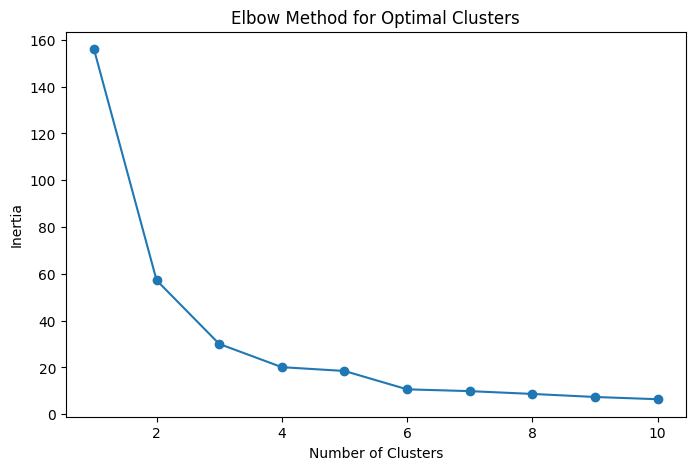

In [27]:
# Use the Elbow Method to determine the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [28]:
# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
team_data['Cluster'] = kmeans.fit_predict(X_scaled)

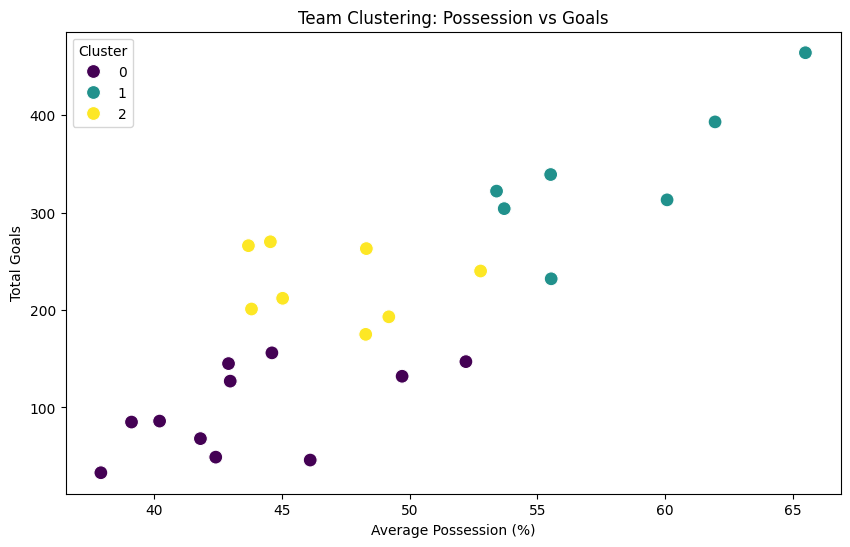

In [32]:
# Visualize clusters using two key metrics (e.g., Possession and Goals)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=team_data, x='AvgPossession', y='TotalGoals', hue='Cluster', palette='viridis', s=100)
plt.title('Team Clustering: Possession vs Goals')
plt.xlabel('Average Possession (%)')
plt.ylabel('Total Goals')
plt.legend(title='Cluster')
plt.show()

In [35]:
# Analyze cluster characteristics (only numeric columns)
cluster_summary = team_data.groupby('Cluster')[features].mean()
print(cluster_summary)
print(team_data[['Team', 'Cluster']])

         AvgPossession  TotalGoals  TotalAssists  TotalExpectedGoals  \
Cluster                                                                
0            43.624242   97.636364          68.0          108.254545   
1            57.957143  338.142857         243.0          325.800000   
2            46.946250  227.500000         159.0          228.137500   

         TotalProgressiveCarries  TotalProgressivePasses  
Cluster                                                   
0                    1368.727273             2903.272727  
1                    4280.285714             9145.285714  
2                    2975.375000             6017.000000  
               Team  Cluster
0           Arsenal        1
1       Aston Villa        2
2       Bournemouth        0
3         Brentford        0
4          Brighton        1
5           Burnley        0
6           Chelsea        1
7    Crystal Palace        2
8           Everton        2
9            Fulham        0
10     Leeds United      

#### Insights from Clustering Analysis

**Cluster 0: Low Possession, Low Goals**  
**Characteristics:**
- Teams in this cluster have low possession percentages and score fewer goals.
- These teams likely adopt a defensive style, focusing on maintaining structure rather than dominating possession or attacking output.  

**Examples:**  
Teams like **Burnley** or **West Bromwich** fall into this cluster, as they are known for their defensive setups and limited attacking contributions.

**Cluster 1: High Possession, High Goals**  
**Characteristics:**
- Teams in this cluster dominate possession and score a high number of goals.
- These teams likely employ a possession-based style of play, controlling games and creating numerous scoring opportunities.  

**Examples:**  
Teams like **Manchester City** or **Liverpool** fall into this cluster, as they are known for their attacking dominance and high possession percentages.

**Cluster 2: Low Possession, Moderate Goals**  
**Characteristics:**  
- Teams in this cluster have low possession but manage to score a moderate number of goals.
- These teams likely rely on counter-attacking strategies or efficient finishing to score goals despite not dominating possession.  

**Examples:**  
Teams like **Newcastle United** and **Leicester City** fall into this cluster, as they are known for their ability to score goals through quick transitions and counter-attacks.

## Conclusions & Key Takeaways

### Alignment with Business Goals:
This project provided a data-driven exploration of player and team performances in the Premier League from 2019/20 to 2024/25, with a focus on addressing business questions related to efficiency, trends, and relationships between key metrics.

---

### League-Level Insights:
- The league shows a **consistent relationship between Expected Goals (xG) and actual goals**, validating xG as a reliable performance indicator across seasons.
- **Disciplinary metrics** (yellow and red cards) have shown a gradual increase, suggesting tactical changes or stricter regulatory changes influencing match discipline.


### Team-Level Insights:
- **Teams with higher possession tend to generate higher xG and actual goals**, affirming that maintaining control of the ball correlates with offensive output.
- **Over- and under-performance relative to xG** is observable across several teams, indicating tactical styles, finishing quality, or defensive lapses influencing results.
- Certain teams show **progressive improvements or declines over multiple seasons**, providing context for recruitment, coaching changes, or tactical adjustments.


### Player-Level Insights:
- **Top goal scorers and assist providers** consistently outperform peers, with several players maintaining elite-level performance across seasons.
- **Positional trends** highlight midfielders and attackers as key contributors to progressive metrics (carries, passes), while defenders focus on build-up and supporting progression.
- Emerging younger players are increasingly contributing to progressive play, offering value to clubs investing in youth development.


### Summary:
- The analysis has successfully uncovered key patterns at both player and team levels.
- Trends, correlations, and efficiency metrics were visualized to aid **stakeholders in talent identification, tactical planning, and performance optimization**.
- These findings directly address business questions around player effectiveness, possession-goal dynamics, defensive vs. attacking trade-offs, and longitudinal trends.


### Next Steps

- **Predictive Modeling Potential**: Leverage the findings from this analysis to develop regression models, classification models, or time-series forecasting to predict key outcomes such as team goal output, player performance (e.g., goals + assists), or team efficiency metrics.
  
- **Dataset Expansion**: Integrate additional advanced metrics from FBref (e.g., pressures, tackles, blocks, pass completion %, shot-creating actions, goal-creating actions) to enrich player and team profiles and improve model accuracy and insight depth.

- **Tactical & Financial Insights**: Extend the project by incorporating external data (e.g., player market values, team wage bills) to link on-pitch performance with financial efficiency or recruitment strategies.

- **Dashboard Creation**: Build interactive dashboards (e.g., using Tableau or Power BI) to communicate findings to non-technical stakeholders like coaches, scouts, and executives.

